# Short term trading strategies that work

In this notebook, strategies mentioned in the book 'Short term trading strategies that work' from Larry Connors are investigated. This book mainly focuses on short-term mean-reversion strategies in the US equity market.

In [1]:
%matplotlib inline
from datetime import datetime
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
plt.style.use('bmh')
import pandas as pd

from vivace.backtest import (BacktestEngine, Strategy, Weighting, InstrumentDef,
                             Performance, signal, processing, rebase, PnLType)
from vivace.backtest.engine import long_only_returns

# Strategy 1
If the following conditions are met, go long the equity market for 5 days.
- It went down 3 days in a row
- Price is above 200 day MA. Rationale is to go long when long-term trend is up and capture temporal pullback.

In [2]:
instruments = ['SPY', 'QQQ', '^GDAXI', '^N225']

In [3]:
def run_strat_1(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.ConsecutiveSign(n_consecutive=3, lookback_direction=-1, position=1)
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine


def run_backtests(backtest_func, instruments):
    result = []

    for name in instruments:
        instrument = InstrumentDef(name, pnl_type=PnLType.ADJCLOSE_TO_ADJCLOSE.value)
        strat_engine = backtest_func(instrument)
        strat_equity_curve = strat_engine.calculate_equity_curve(calculate_net=False).rename(f'Strategy ({name})')
        long_only = long_only_returns(instrument, strat_equity_curve.index[0], strat_equity_curve.index[-1])
        long_only_equity_curve = long_only.add(1).cumprod().rename(f'Long-only ({name})')

        result.append(
            pd.concat((long_only_equity_curve, strat_equity_curve), axis=1).pipe(rebase)
        )
    return result

In [4]:
strategy_1_result = run_backtests(run_strat_1, instruments)

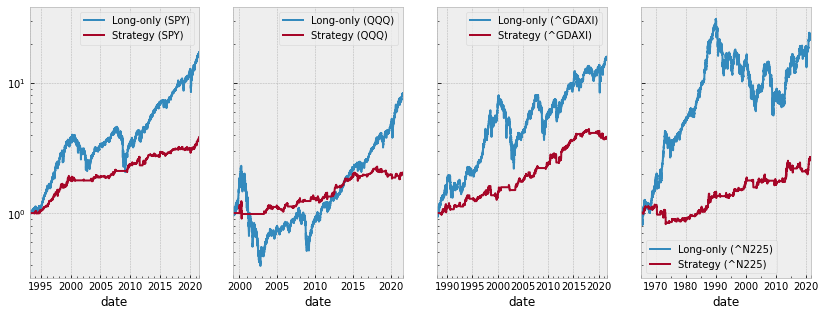

In [5]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_1_result):
    result.plot(ax=ax, logy=True)

In [6]:
pd.concat([i.pipe(Performance).summary() for i in strategy_1_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.095997,0.045472,0.090990,0.030813,0.079122,0.038617,0.052323,0.016154
Annualised vol,0.184506,0.068907,0.272353,0.094424,0.219013,0.079988,0.195839,0.067719
Sharpe ratio,0.520294,0.659908,0.334087,0.326325,0.361267,0.482784,0.267174,0.238537
Max drawdown,0.551894,0.140756,0.829639,0.265982,0.726848,0.217462,0.818712,0.292850
Calmar ratio,0.173942,0.323058,0.109674,0.115846,0.108856,0.177580,0.063909,0.055160
Skewness,-0.051284,-1.127116,0.239414,1.685862,-0.131511,-1.967612,-0.198986,-4.080239
Kurtosis,12.680228,47.417110,7.552942,88.344949,6.846693,75.958230,9.724540,166.562421
Worst return,-0.109424,-0.072474,-0.119788,-0.086647,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072474,-0.119788,-0.086647,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1w return,-0.197934,-0.128281,-0.246190,-0.246190,-0.233039,-0.131434,-0.243342,-0.149009


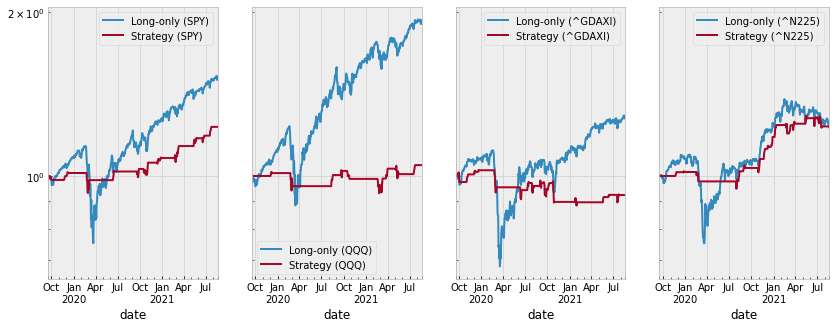

In [7]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_1_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 2

If the following conditions are met, go long the equity market for 5 days.
- It the market made new 10-day lows
- Price is above 200 day MA. Rationale is to go long when long-term trend is up and capture temporal pullback.

In [8]:
def run_strat_2(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.LocalMinimum(lookback=10, shift=1)
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [9]:
strategy_2_result = run_backtests(run_strat_2, instruments)

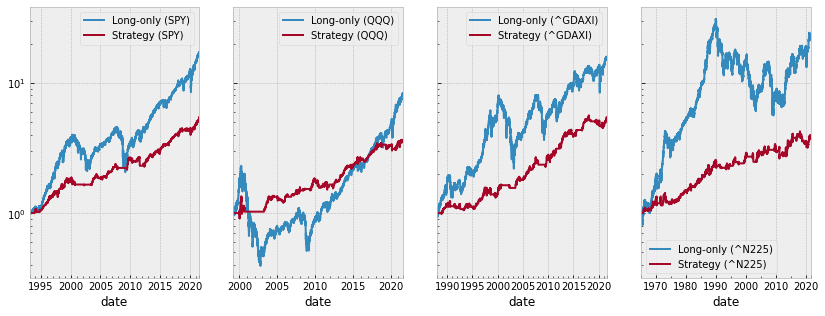

In [10]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_2_result):
    result.plot(ax=ax, logy=True)

In [11]:
pd.concat([i.pipe(Performance).summary() for i in strategy_2_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.095997,0.057327,0.090990,0.055665,0.079122,0.048612,0.052323,0.022907
Annualised vol,0.184506,0.080355,0.272353,0.114866,0.219013,0.088301,0.195839,0.085021
Sharpe ratio,0.520294,0.713419,0.334087,0.484611,0.361267,0.550530,0.267174,0.269429
Max drawdown,0.551894,0.160132,0.829639,0.265982,0.726848,0.201483,0.818712,0.251076
Calmar ratio,0.173942,0.357996,0.109674,0.209282,0.108856,0.241271,0.063909,0.091236
Skewness,-0.051284,-0.777099,0.239414,0.701663,-0.131511,-0.073624,-0.198986,-2.532183
Kurtosis,12.680228,30.251284,7.552942,48.020324,6.846693,16.438156,9.724540,86.714768
Worst return,-0.109424,-0.072474,-0.119788,-0.086647,-0.131434,-0.058299,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072474,-0.119788,-0.086647,-0.131434,-0.058299,-0.149009,-0.149009
Worst 1w return,-0.197934,-0.128281,-0.246190,-0.246190,-0.233039,-0.126251,-0.243342,-0.175308


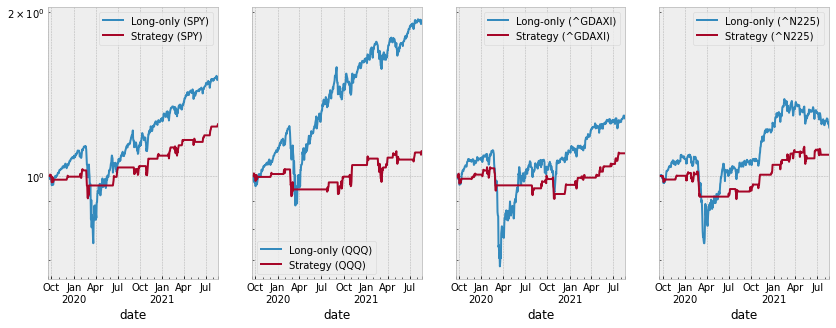

In [12]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_2_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 3

This strategy is the so-called "Double 7's strategy".

In [13]:
def run_strat_3(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Double7Connors(),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [14]:
strategy_3_result = run_backtests(run_strat_3, instruments)

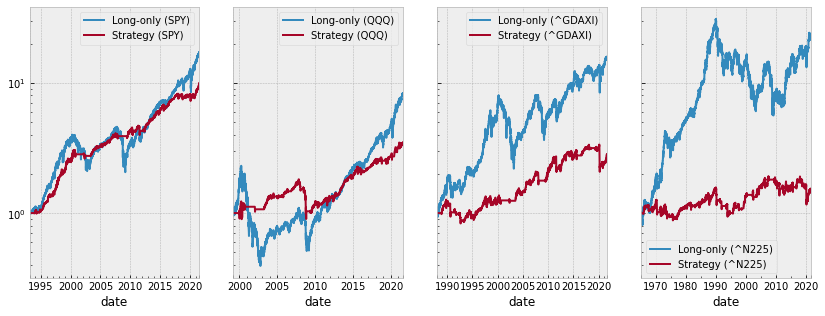

In [15]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_3_result):
    result.plot(ax=ax, logy=True)

In [16]:
pd.concat([i.pipe(Performance).summary() for i in strategy_3_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.095997,0.077754,0.090990,0.053795,0.079122,0.029792,0.052323,0.007307
Annualised vol,0.184506,0.096713,0.272353,0.143448,0.219013,0.116088,0.195839,0.103121
Sharpe ratio,0.520294,0.803971,0.334087,0.375017,0.361267,0.256632,0.267174,0.070859
Max drawdown,0.551894,0.153225,0.829639,0.503464,0.726848,0.382193,0.818712,0.404694
Calmar ratio,0.173942,0.507449,0.109674,0.106850,0.108856,0.077950,0.063909,0.018056
Skewness,-0.051284,-0.311243,0.239414,0.674824,-0.131511,-1.254006,-0.198986,-1.640699
Kurtosis,12.680228,19.094941,7.552942,34.053506,6.846693,39.527727,9.724540,49.293223
Worst return,-0.109424,-0.072474,-0.119788,-0.089557,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072474,-0.119788,-0.089557,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1w return,-0.197934,-0.128281,-0.246190,-0.246190,-0.233039,-0.233039,-0.243342,-0.182423


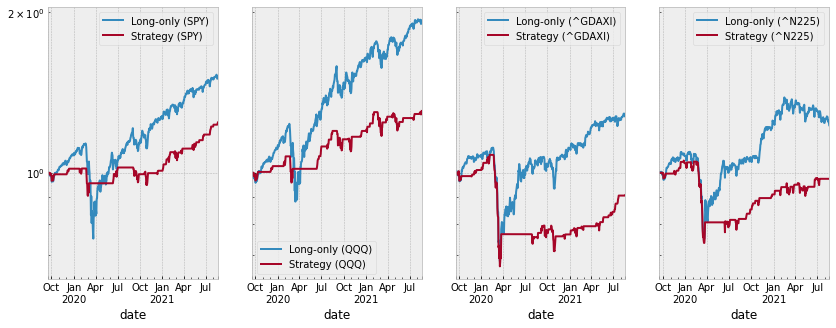

In [17]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_3_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 4
Month-end strategy which goes long when the following conditions are met:
- n days before month-end
    - (optional) only do so when the previous day is down
- The price is above 200 day MA

In [18]:
def run_strat_4(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.MonthEndLong(n_before=5, n_after=0, is_prev_neg=True),
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [19]:
strategy_4_result = run_backtests(run_strat_4, instruments)

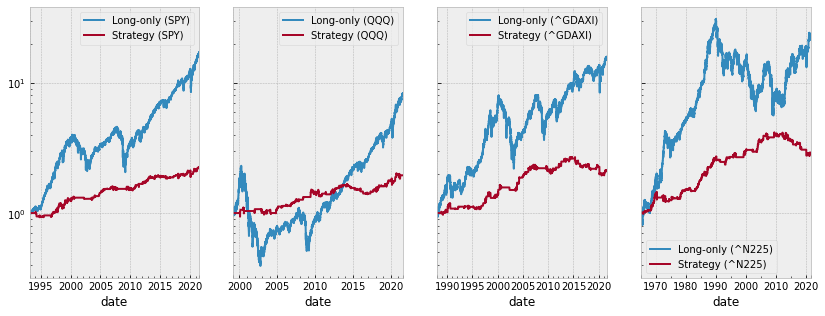

In [20]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_4_result):
    result.plot(ax=ax, logy=True)

In [21]:
pd.concat([i.pipe(Performance).summary() for i in strategy_4_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.095997,0.027520,0.090990,0.028722,0.079122,0.021555,0.052323,0.018013
Annualised vol,0.184506,0.059748,0.272353,0.076252,0.219013,0.063163,0.195839,0.052166
Sharpe ratio,0.520294,0.460594,0.334087,0.376676,0.361267,0.341264,0.267174,0.345312
Max drawdown,0.551894,0.111611,0.829639,0.166739,0.726848,0.280084,0.818712,0.341473
Calmar ratio,0.173942,0.246567,0.109674,0.172260,0.108856,0.076960,0.063909,0.052752
Skewness,-0.051284,-0.852697,0.239414,-0.510611,-0.131511,-0.283306,-0.198986,-2.445618
Kurtosis,12.680228,54.329400,7.552942,33.083367,6.846693,29.352560,9.724540,105.605682
Worst return,-0.109424,-0.072474,-0.119788,-0.054422,-0.131434,-0.048098,-0.149009,-0.086856
Worst 1d return,-0.109424,-0.072474,-0.119788,-0.054422,-0.131434,-0.048098,-0.149009,-0.086856
Worst 1w return,-0.197934,-0.111611,-0.246190,-0.106961,-0.233039,-0.124379,-0.243342,-0.127345


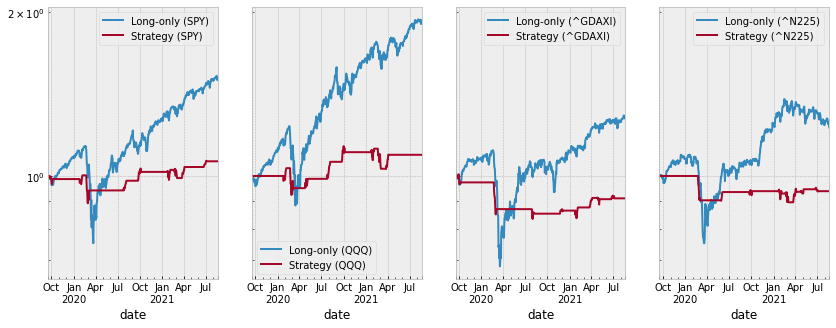

In [22]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_4_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Reference
- Connors, L.A. and Alvarez, C., 2009. Short Term Trading Strategies that Work: A Quantified Guide to Trading Stocks and ETFs. TradingMarkets Publishing Group.

In [23]:
print(f'Updated: {datetime.utcnow():%d-%b-%Y %H:%M}')

Updated: 22-Aug-2021 07:01
